### **This script generates descriptors for the classification task. If you want to use it for regression, just change it a little bit according to the comments in the appropriate code blocks**

In [ ]:
!pip install rdkit

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, GraphDescriptors, Lipinski, QED, rdMolDescriptors, Fragments, FragmentMatcher
from rdkit.Chem.EState.EState_VSA import VSA_EState_
from tqdm import tqdm

In [ ]:
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression

In [ ]:
filename = 'classification_dataset_without_descriptors.csv' # write the name of your file here
df = pd.read_csv(filename)
df.head()

,SMILES,Activity,Agglomeration,SMILES_uncharge,FORMAL_CHARGE_unch
0,BrC(Br)Br,1,False,BrC(Br)Br,0
1,C#CC(C)(O)CC,1,False,C#CC(C)(O)CC,0
2,C#CC(O)(/C=C/Cl)CC,1,False,C#CC(O)(/C=C/Cl)CC,0
3,C#CC(OC(N)=O)c1ccccc1,1,False,C#CC(OC(N)=O)C1=CC=CC=C1,0
4,C#CC1(OCC(O)CN2CCN(c3ccc(F)cc3)CC2)CCCCC1,1,False,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,0


In [ ]:
df = df[['SMILES_uncharge', 'Activity']]


In [ ]:
df = df.rename(columns={'SMILES_uncharge':'SMILES'})
df.head()

,SMILES,Activity
0,BrC(Br)Br,1
1,C#CC(C)(O)CC,1
2,C#CC(O)(/C=C/Cl)CC,1
3,C#CC(OC(N)=O)C1=CC=CC=C1,1
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1


### QED and Crippen modules

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    df.at[i, '#HBA'] = qed_vector[2]
    df.at[i, '#HBD'] = qed_vector[3]
    df.at[i, 'PSA'] = qed_vector[4]
    df.at[i, '#ROTB'] = qed_vector[5]
    df.at[i, '#ALERTS'] = qed_vector[7]

    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    df.at[i, '#MR'] = round(Crippen.MolMR(mol), 2)

df.head()

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66


### Lipinski module

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, '#HeavyAtoms'] = Lipinski.HeavyAtomCount(mol)
    df.at[i, '#NHOH'] = Lipinski.NHOHCount(mol)
    df.at[i, '#NO'] = Lipinski.NOCount(mol)
    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)

df.head()

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,#NHOH,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,4.0,0.0,0.0,0.0,0.0,3.0
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,7.0,1.0,1.0,0.0,0.0,1.0
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,9.0,1.0,1.0,0.0,0.0,2.0
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,13.0,2.0,3.0,1.0,0.0,3.0
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,26.0,1.0,4.0,1.0,0.0,5.0


### Descriptors module

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'Morgan2'] =  round(Descriptors.FpDensityMorgan2(mol), 2)
    df.at[i, 'Morgan3'] =  round(Descriptors.FpDensityMorgan3(mol), 2)
    df.at[i, 'HeavyAtomMW'] =  round(Descriptors.HeavyAtomMolWt(mol), 2)
    df.at[i, 'MaxPartialCharge'] = Descriptors.MaxPartialCharge(mol)
    df.at[i, 'MinPartialCharge'] = Descriptors.MinPartialCharge(mol)
    df.at[i, '#ValenceElectrons'] = Descriptors.NumValenceElectrons(mol)

df.head()

Выходные данные были обрезаны до нескольких последних строк (5000).
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use MorganGenerator
[20:03:13] DEPRECATION WARNING: please use Morg

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,#NO,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,...,0.0,0.0,0.0,3.0,1.00,1.00,251.72,0.124221,-0.063717,26.0
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,...,1.0,0.0,0.0,1.0,2.29,2.29,88.06,0.121725,-0.377933,40.0
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,...,1.0,0.0,0.0,2.0,2.44,2.56,135.53,0.144219,-0.373980,50.0
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,...,3.0,1.0,0.0,3.0,2.08,2.54,166.11,0.405593,-0.428173,66.0
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,...,4.0,1.0,0.0,5.0,1.77,2.38,331.24,0.128054,-0.389382,142.0


### GraphDescriptors module

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    df.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
df.head()

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,#AromaticHeterocycles,#Heteroatoms,Morgan2,Morgan3,HeavyAtomMW,MaxPartialCharge,MinPartialCharge,#ValenceElectrons,BertzCT,Kappa1
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,...,0.0,3.0,1.00,1.00,251.72,0.124221,-0.063717,26.0,8.00,5.44
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,...,0.0,1.0,2.29,2.29,88.06,0.121725,-0.377933,40.0,86.84,6.52
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,...,0.0,2.0,2.44,2.56,135.53,0.144219,-0.373980,50.0,145.49,8.55
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,...,0.0,3.0,2.08,2.54,166.11,0.405593,-0.428173,66.0,326.53,9.14
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,...,0.0,5.0,1.77,2.38,331.24,0.128054,-0.389382,142.0,599.43,19.16


### Fragment descriptors

In [ ]:
uniq_el = set([])
uniq_bond = set([])
for mol_sm in tqdm(df['SMILES']):
    mol_sm_rd = Chem.MolFromSmiles(mol_sm)
    list_atomic = [x.GetSymbol() for x in mol_sm_rd.GetAtoms()]
    uniq_el = uniq_el | set(list_atomic)
    list_bond = [str(x.GetBondType()) for x in Chem.MolFromSmiles(mol_sm).GetBonds()]
    uniq_bond = uniq_bond | set(list_bond)

uniq_el = list(uniq_el)
print(uniq_el)
np.save('BBB_uniq_el', np.array(uniq_el))
uniq_bond = list(uniq_bond)
print(uniq_bond)

100%|██████████| 6748/6748 [00:04<00:00, 1504.75it/s]

['Si', 'F', 'P', 'Cl', 'O', 'Br', 'N', 'S', 'B', 'C', 'I']
['SINGLE', 'DOUBLE', 'AROMATIC', 'TRIPLE']


In [ ]:
list_dop_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)

    num_atom = mol_sm.GetNumAtoms()

    # the amount of each element in the molecule
    list_atomic_num = [x.GetSymbol() for x in mol_sm.GetAtoms()]
    list_count_atom = [list_atomic_num.count(x) for x in uniq_el]

    # number of each bond type and bond analysis
    list_bond = list(np.array([x.GetBondType() for x in mol_sm.GetBonds()], dtype=str))
    list_count_bond = [list_bond.count(x) for x in uniq_bond]


    AlCOO = Fragments.fr_Al_COO(mol_sm)
    AlOH = Fragments.fr_Al_OH(mol_sm)
    AlOHnt = Fragments.fr_Al_OH_noTert(mol_sm)
    ArN = Fragments.fr_ArN(mol_sm)
    ArCOO = Fragments.fr_Ar_COO(mol_sm)
    Ar_N = Fragments.fr_Ar_N(mol_sm)
    ArNH = Fragments.fr_Ar_NH(mol_sm)
    ArOH = Fragments.fr_Ar_OH(mol_sm)
    COO = Fragments.fr_COO(mol_sm)
    CO = Fragments.fr_C_O(mol_sm)
    CO_clean = Fragments.fr_C_O_noCOO(mol_sm)
    CS = Fragments.fr_C_S(mol_sm)
    HOCCN = Fragments.fr_HOCCN(mol_sm)
    Imine = Fragments.fr_Imine(mol_sm)
    NHtert = Fragments.fr_NH0(mol_sm)
    NHsec = Fragments.fr_NH1(mol_sm)
    NHpri = Fragments.fr_NH2(mol_sm)
    NO = Fragments.fr_N_O(mol_sm)
    XCCNR = Fragments.fr_Ndealkylation1(mol_sm)
    TACA = Fragments.fr_Ndealkylation2(mol_sm)
    Npyrrl = Fragments.fr_Nhpyrrole(mol_sm)
    SH = Fragments.fr_SH(mol_sm)
    Ald = Fragments.fr_aldehyde(mol_sm)
    Alk_carb = Fragments.fr_alkyl_carbamate(mol_sm)
    Alk_hal = Fragments.fr_alkyl_halide(mol_sm)
    Alk_oxid = Fragments.fr_allylic_oxid(mol_sm)
    Amide = Fragments.fr_amide(mol_sm)
    Amidine = Fragments.fr_amidine(mol_sm)
    Aniline = Fragments.fr_aniline(mol_sm)
    Ar_methyl = Fragments.fr_aryl_methyl(mol_sm)
    Azide = Fragments.fr_azide(mol_sm)
    Azo = Fragments.fr_azo(mol_sm)
    Barb = Fragments.fr_barbitur(mol_sm)
    Benz = Fragments.fr_benzene(mol_sm)
    BenzD = Fragments.fr_benzodiazepine(mol_sm)
    Bicycl = Fragments.fr_bicyclic(mol_sm)
    Diazo = Fragments.fr_diazo(mol_sm)
    DHpyridine = Fragments.fr_dihydropyridine(mol_sm)
    Epoxide = Fragments.fr_epoxide(mol_sm)
    Ester = Fragments.fr_ester(mol_sm)
    EtherO = Fragments.fr_ether(mol_sm)
    Furan = Fragments.fr_furan(mol_sm)
    Guanid = Fragments.fr_guanido(mol_sm)
    Hal = Fragments.fr_halogen(mol_sm)
    Hdrzine = Fragments.fr_hdrzine(mol_sm)
    Hdrzone = Fragments.fr_hdrzone(mol_sm)
    Imidazole = Fragments.fr_imidazole(mol_sm)
    Imide = Fragments.fr_imide(mol_sm)
    RNCO = Fragments.fr_isocyan(mol_sm)
    RNCS = Fragments.fr_isothiocyan(mol_sm)
    Ket = Fragments.fr_ketone(mol_sm)
    Ket2 = Fragments.fr_ketone_Topliss(mol_sm)
    Lactam = Fragments.fr_lactam(mol_sm)
    Lactone = Fragments.fr_lactone(mol_sm)
    OMe = Fragments.fr_methoxy(mol_sm)
    Morphlne = Fragments.fr_morpholine(mol_sm)
    RCN = Fragments.fr_nitrile(mol_sm)
    Nitro = Fragments.fr_nitro(mol_sm)
    NitroAr = Fragments.fr_nitro_arom(mol_sm)
    NitroArno = Fragments.fr_nitro_arom_nonortho(mol_sm)
    RNO = Fragments.fr_nitroso(mol_sm)
    Oxaz = Fragments.fr_oxazole(mol_sm)
    Oxime = Fragments.fr_oxime(mol_sm)
    paraHX = Fragments.fr_para_hydroxylation(mol_sm)
    PhOH = Fragments.fr_phenol(mol_sm)
    PhOHno = Fragments.fr_phenol_noOrthoHbond(mol_sm)
    PAcide = Fragments.fr_phos_acid(mol_sm)
    PEster = Fragments.fr_phos_ester(mol_sm)
    Piprdn = Fragments.fr_piperdine(mol_sm)
    Piprzn = Fragments.fr_piperzine(mol_sm)
    Priamide = Fragments.fr_priamide(mol_sm)
    Prisulfamd = Fragments.fr_prisulfonamd(mol_sm)
    PyrRing = Fragments.fr_pyridine(mol_sm)
    Nquat = Fragments.fr_quatN(mol_sm)
    Sether = Fragments.fr_sulfide(mol_sm)
    Sulfamd = Fragments.fr_sulfonamd(mol_sm)
    Sulfone = Fragments.fr_sulfone(mol_sm)
    TermCHCH = Fragments.fr_term_acetylene(mol_sm)
    Tetrazol = Fragments.fr_tetrazole(mol_sm)
    Thiazole = Fragments.fr_thiazole(mol_sm)
    RSCN = Fragments.fr_thiocyan(mol_sm)
    Thioph = Fragments.fr_thiophene(mol_sm)
    UNb_alk = Fragments.fr_unbrch_alkane(mol_sm)
    Urea = Fragments.fr_urea(mol_sm)


    list_desc = list_count_atom + list_count_bond + [num_atom,
               AlCOO, AlOH, AlOHnt, ArN, ArCOO, Ar_N, ArNH, ArOH, COO, CO, CO_clean, CS, HOCCN,
               Imine, NHtert, NHsec, NHpri, NO, XCCNR, TACA, Npyrrl, SH, Ald, Alk_carb, Alk_hal,
               Alk_oxid, Amide, Amidine, Aniline, Ar_methyl, Azide, Azo, Barb, Benz, BenzD,
               Bicycl, Diazo, DHpyridine, Epoxide, Ester, EtherO, Furan, Guanid, Hal, Hdrzine,
               Hdrzone, Imidazole, Imide, RNCO, RNCS, Ket, Ket2, Lactam, Lactone, OMe, Morphlne,
               RCN, Nitro, NitroAr, NitroArno, RNO, Oxaz, Oxime, paraHX, PhOH, PhOHno, PAcide,
               PEster, Piprdn, Piprzn, Priamide, Prisulfamd, PyrRing, Nquat, Sether, Sulfamd,
               Sulfone, TermCHCH, Tetrazol, Thiazole, RSCN, Thioph, UNb_alk, Urea]
    list_dop_descript.append(list_desc)

list_dop_descript = np.array(list_dop_descript)

100%|██████████| 6748/6748 [00:11<00:00, 591.17it/s]


In [ ]:
list_dop_descript.shape

(6748, 100)

In [ ]:
dop_desc_name = uniq_el + uniq_bond + ['num_atom',
            'AlCOO', 'AlOH', 'AlOHnt', 'ArN', 'ArCOO', 'Ar_N', 'ArNH', 'ArOH', 'COO',
            'CO', 'CO_clean', 'CS', 'HOCCN',
            'Imine', 'NHtert', 'NHsec', 'NHpri', 'NO', 'XCCNR', 'TACA', 'Npyrrl', 'SH',
            'Ald', 'Alk_carb', 'Alk_hal',
            'Alk_oxid', 'Amide', 'Amidine', 'Aniline', 'Ar_methyl', 'Azide', 'Azo', 'Barb', 'Benz', 'BenzD',
            'Bicycl', 'Diazo', 'DHpyridine', 'Epoxide', 'Ester',
            'EtherO', 'Furan', 'Guanid', 'Hal', 'Hdrzine',
            'Hdrzone', 'Imidazole', 'Imide', 'RNCO', 'RNCS', 'Ket',
            'Ket2', 'Lactam', 'Lactone', 'OMe', 'Morphlne',
            'RCN', 'Nitro', 'NitroAr', 'NitroArno', 'RNO', 'Oxaz', 'Oxime', 'paraHX', 'PhOH', 'PhOHno', 'PAcide',
            'PEster', 'Piprdn', 'Piprzn', 'Priamide', 'Prisulfamd', 'PyrRing', 'Nquat', 'Sether', 'Sulfamd',
            'Sulfone', 'TermCHCH', 'Tetrazol', 'Thiazole', 'RSCN', 'Thioph', 'UNb_alk', 'Urea']

dop_desc_name_new = [str(x) + '_dop' for x in dop_desc_name]
print(dop_desc_name_new)

dop_mass_one = list_dop_descript.copy()
dop_mass_one[dop_mass_one != 0] = 1
dop_mass_one = np.sum(dop_mass_one, axis=0)

['Si_dop', 'F_dop', 'P_dop', 'Cl_dop', 'O_dop', 'Br_dop', 'N_dop', 'S_dop', 'B_dop', 'C_dop', 'I_dop', 'SINGLE_dop', 'DOUBLE_dop', 'AROMATIC_dop', 'TRIPLE_dop', 'num_atom_dop', 'AlCOO_dop', 'AlOH_dop', 'AlOHnt_dop', 'ArN_dop', 'ArCOO_dop', 'Ar_N_dop', 'ArNH_dop', 'ArOH_dop', 'COO_dop', 'CO_dop', 'CO_clean_dop', 'CS_dop', 'HOCCN_dop', 'Imine_dop', 'NHtert_dop', 'NHsec_dop', 'NHpri_dop', 'NO_dop', 'XCCNR_dop', 'TACA_dop', 'Npyrrl_dop', 'SH_dop', 'Ald_dop', 'Alk_carb_dop', 'Alk_hal_dop', 'Alk_oxid_dop', 'Amide_dop', 'Amidine_dop', 'Aniline_dop', 'Ar_methyl_dop', 'Azide_dop', 'Azo_dop', 'Barb_dop', 'Benz_dop', 'BenzD_dop', 'Bicycl_dop', 'Diazo_dop', 'DHpyridine_dop', 'Epoxide_dop', 'Ester_dop', 'EtherO_dop', 'Furan_dop', 'Guanid_dop', 'Hal_dop', 'Hdrzine_dop', 'Hdrzone_dop', 'Imidazole_dop', 'Imide_dop', 'RNCO_dop', 'RNCS_dop', 'Ket_dop', 'Ket2_dop', 'Lactam_dop', 'Lactone_dop', 'OMe_dop', 'Morphlne_dop', 'RCN_dop', 'Nitro_dop', 'NitroAr_dop', 'NitroArno_dop', 'RNO_dop', 'Oxaz_dop', 'Oxime

In [ ]:
print(dop_mass_one.shape)
print(dop_mass_one)

(100,)
[   1  957   51 1089 6229  101 5441 1685    2 6748   28 6747 5571 4897
  219 6748  990 2734 2395  380   92 1591  400  872 1072 4693 4493   41
  171  314 4296 2853 1381   57 1175 1001  400   15   78   49  859 1444
 2620  120 1348  891    6    4   50 4217   71 4102    0   16   54 1457
 3448  122   65 1962   67   43  230  226    0    0 1626 1474  739  282
 1086   85  133   92   67   45    7   15  239  726  805  797   15   15
  974  395  312    0  449   84  942  178  162   64  102  236    0  114
  299  210]


<ipython-input-70-5fecf1f943cf>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))


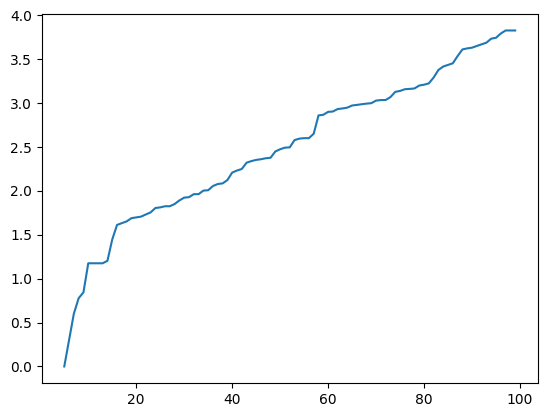

In [ ]:
plt.plot(np.arange(len(dop_mass_one)), np.log10(np.sort(dop_mass_one)))

In [ ]:
w = np.where(dop_mass_one > -1)[0]
df_dop_desc = pd.DataFrame(list_dop_descript, columns=np.array(dop_desc_name_new, dtype=str)) #first set
print('dop desc', df_dop_desc.shape)
print('left dop feat', len(w))
df_dop_desc = df_dop_desc.iloc[:, w]
print('dop desc new', df_dop_desc.shape)

dop desc (6748, 100)
left dop feat 100
dop desc new (6748, 100)


In [ ]:
df_dop_desc['Activity'] = df['Activity'].values
columns = list(df_dop_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_dop_desc = df_dop_desc.loc[:, columns]
df_dop_desc.head(5)

,Activity,Si_dop,F_dop,P_dop,Cl_dop,O_dop,Br_dop,N_dop,S_dop,B_dop,...,Sether_dop,Sulfamd_dop,Sulfone_dop,TermCHCH_dop,Tetrazol_dop,Thiazole_dop,RSCN_dop,Thioph_dop,UNb_alk_dop,Urea_dop
0,1,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,2,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,1,0,0,2,0,2,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_corr = df_dop_desc.corr()
df_corr

,Activity,Si_dop,F_dop,P_dop,Cl_dop,O_dop,Br_dop,N_dop,S_dop,B_dop,...,Sether_dop,Sulfamd_dop,Sulfone_dop,TermCHCH_dop,Tetrazol_dop,Thiazole_dop,RSCN_dop,Thioph_dop,UNb_alk_dop,Urea_dop
Activity,1.000000,-0.014801,0.126749,-0.052363,0.094038,-0.426776,0.040965,-0.364926,-0.294040,0.014162,...,-0.318941,-0.064239,0.002283,0.015039,-0.133289,-0.178433,NaN,-0.024055,0.002285,0.026302
Si_dop,-0.014801,1.000000,-0.003920,-0.000992,-0.004141,-0.007894,-0.001400,-0.012773,-0.006110,-0.000210,...,-0.004484,-0.001923,-0.001898,-0.001191,-0.001508,-0.002240,NaN,-0.001556,-0.001699,-0.002145
F_dop,0.126749,-0.003920,1.000000,-0.019392,-0.016258,-0.063381,0.044224,-0.111966,-0.056308,0.006031,...,-0.040970,-0.002835,-0.028467,-0.013005,0.010734,-0.054421,NaN,-0.025529,-0.018631,-0.028471
P_dop,-0.052363,-0.000992,-0.019392,1.000000,0.022257,0.041267,-0.009375,-0.011484,-0.013019,-0.001403,...,-0.002303,-0.006053,-0.012704,-0.007975,-0.010096,-0.014992,NaN,-0.010416,0.002134,-0.000469
Cl_dop,0.094038,-0.004141,-0.016258,0.022257,1.000000,-0.039935,-0.024957,-0.052949,-0.061910,-0.005857,...,-0.061050,0.021274,0.031261,-0.017726,-0.042139,-0.058412,NaN,-0.005087,-0.021570,-0.024680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thiazole_dop,-0.178433,-0.002240,-0.054421,-0.014992,-0.058412,0.076315,-0.016453,0.297129,0.484500,-0.003168,...,0.267181,-0.009890,-0.028678,-0.018002,0.071078,1.000000,NaN,-0.023512,-0.025671,-0.005084
RSCN_dop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Thioph_dop,-0.024055,-0.001556,-0.025529,-0.010416,-0.005087,-0.027837,0.006143,-0.004010,0.219573,-0.002201,...,0.033383,0.036393,-0.006373,-0.012506,-0.015833,-0.023512,NaN,1.000000,-0.014100,-0.005235
UNb_alk_dop,0.002285,-0.001699,-0.018631,0.002134,-0.021570,0.002542,-0.009159,-0.032927,-0.036638,-0.002403,...,-0.035052,0.015379,-0.021753,-0.013655,-0.007268,-0.025671,NaN,-0.014100,1.000000,-0.006488


In [ ]:
act_row = df_corr.iloc[0]
print(act_row.sort_values().to_string())

O_dop            -0.426776
Lactam_dop       -0.407971
COO_dop          -0.384150
AlCOO_dop        -0.369626
N_dop            -0.364926
num_atom_dop     -0.327417
Sether_dop       -0.318941
CO_dop           -0.303391
DOUBLE_dop       -0.297120
S_dop            -0.294040
NHpri_dop        -0.285315
Amide_dop        -0.271517
NHsec_dop        -0.254359
SINGLE_dop       -0.241412
CO_clean_dop     -0.215505
AlOHnt_dop       -0.201751
AlOH_dop         -0.201159
ArOH_dop         -0.199126
NHtert_dop       -0.193536
PhOH_dop         -0.193021
PhOHno_dop       -0.191465
Oxime_dop        -0.190251
C_dop            -0.181410
Thiazole_dop     -0.178433
Ar_N_dop         -0.166278
EtherO_dop       -0.159736
ArN_dop          -0.155787
Tetrazol_dop     -0.133289
Lactone_dop      -0.126553
ArCOO_dop        -0.098715
Nquat_dop        -0.098392
Ald_dop          -0.089086
Ester_dop        -0.081166
Guanid_dop       -0.078596
AROMATIC_dop     -0.078587
Priamide_dop     -0.070615
OMe_dop          -0.067208
S

In [ ]:
fragments_list = np.load('BBB_features.npy')
fgraments_list = fragments_list[-474:]
fgraments_list

array(['cc-c(c)ccc', 'ccccs', 'ccccN', 'cccnc', 'cccc(c)-cn', 'csccn',
       'c1cscn1', 'ccsc(n)N', 'cncN', 'cnc(c)-c', 'cccc-c(c)n', 'ccncN',
       'ccc(c)-c(c)n', 'ccc-c(c)nc', 'cccncN', 'ccc(c)-cnc',
       'cnc(c)-c(c)c', 'ccccNC', 'cc(c)CN', 'cnccn', 'ccccn', 'cccc(c)nc',
       'cncNCC', 'cccc(c)CN', 'cnc(c)cn', 'ccccnc', 'ccc(cc)CN',
       'cnc(c)c(c)n', 'cccncNC', 'ccccncN', 'CCO', 'CCOC', 'COC(C)O',
       'CCCO', 'OCCO', 'CCC(C)O', 'CC[C@@H](C)O', 'CCCOC', 'CO[C@H](C)C',
       'CCCOCC', 'cccc(c)N', 'ccccc(c)N', 'cc(-c)ccN', 'ccccc(c)O',
       'cccc(c)CC', 'cccc(c)OC', 'CCC(C)C', 'ccc(c)CCC', 'ccc(c)OCC',
       'cc(c)CCCC', 'CCC(C)CC', 'cc(c)OCCC', 'CCCCO', 'CCC(C)COc',
       'cc(O)cccC', 'cccco', 'cccc(c)cc', 'ccc(cc)OC', 'ccccNCC',
       'cccc(c)NC', 'ccc(N)nc', 'ccccN(C)C', 'CNCCN', 'CCN(C)C',
       'ccc(c)CNC', 'ccc(c)NCC', 'cccncc', 'ccc(n)NCC', 'cc(n)N(C)CC',
       'CNCCN(c)C', 'cccN(C)CC', 'ccc(c)N(C)C', 'CCNCCN', 'CCNCC',
       'CCN(C)CC', 'cc(c)CNCC', 'cc(c

In [ ]:
list_main_descript = []
for mol_i in tqdm(df['SMILES']):
    mol_sm = Chem.MolFromSmiles(mol_i)
    mol_frags_list = []
    for ii in range(len(fgraments_list)):
        p = FragmentMatcher.FragmentMatcher()
        p.Init(fgraments_list[ii])
        mol_frags_list.append(len(p.GetMatches(mol_sm)))
    list_main_descript.append(mol_frags_list)

list_main_descript = np.array(list_main_descript)
print(list_main_descript.shape)

100%|██████████| 6748/6748 [01:50<00:00, 61.26it/s]


(6748, 474)


In [ ]:
df_main_desc = pd.DataFrame(list_main_descript, columns=fgraments_list)
df_main_desc.describe()

,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,cnc(c)-c,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
count,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.00000,6748.000000,6748.000000,6748.000000,6748.000000,...,6748.000000,6748.000000,6748.000000,6748.00000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000,6748.000000
mean,0.105216,0.031713,0.397599,0.545643,0.049052,0.03853,0.038085,0.032602,0.086989,0.012745,...,0.040456,0.060462,0.002816,0.03364,0.033047,0.064908,0.082247,0.038826,0.275044,0.225993
std,0.850400,0.256301,1.002313,1.559308,0.424666,0.20874,0.207039,0.184965,0.361136,0.122292,...,0.359082,0.448526,0.052992,0.24632,0.248795,0.332867,0.544908,0.349856,0.902175,0.567689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,24.000000,6.000000,8.000000,18.000000,8.000000,2.00000,2.000000,2.000000,6.000000,3.000000,...,6.000000,8.000000,1.000000,2.00000,2.000000,4.000000,7.000000,4.000000,18.000000,6.000000


In [ ]:
df_main_desc['Activity'] = df['Activity'].values
columns = list(df_main_desc.columns.values)
columns = [columns[-1]] + columns[:-1]
df_main_desc = df_main_desc.loc[:, columns]
df_main_desc.head(5)

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_corr = df_main_desc.corr()
df_corr

,Activity,cc-c(c)ccc,ccccs,ccccN,cccnc,cccc(c)-cn,csccn,c1cscn1,ccsc(n)N,cncN,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
Activity,1.000000,-0.072287,-0.018440,0.025516,-0.043630,-0.066462,-0.179569,-0.178433,-0.183283,-0.109687,...,0.043041,0.041514,0.043706,0.087810,0.084977,0.132266,0.048761,0.075745,0.145302,0.041707
cc-c(c)ccc,-0.072287,1.000000,-0.001711,-0.004920,0.182032,0.394886,-0.014492,-0.014345,-0.014273,0.010250,...,-0.006176,-0.010464,-0.006575,-0.016900,-0.016437,-0.024130,-0.018038,-0.013733,-0.034828,0.104244
ccccs,-0.018440,-0.001711,1.000000,0.034567,0.030126,0.034728,0.126756,0.116890,0.153268,0.027837,...,0.032760,0.047782,0.146201,-0.014553,-0.014113,-0.015445,-0.016556,-0.013734,-0.031959,0.011855
ccccN,0.025516,-0.004920,0.034567,1.000000,0.074542,-0.015184,-0.042770,-0.045127,-0.026759,0.048976,...,-0.038110,-0.021173,-0.004337,0.453693,0.444182,-0.072921,-0.027047,-0.025432,-0.018021,0.181988
cccnc,-0.043630,0.182032,0.030126,0.074542,1.000000,0.195711,-0.024529,-0.025815,-0.022632,0.227591,...,0.072540,0.047762,0.015485,-0.042780,-0.038082,-0.037405,-0.045673,-0.034765,-0.073826,0.121373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCC(c)[C@@H](C)C,0.132266,-0.024130,-0.015445,-0.072921,-0.037405,-0.022527,-0.035999,-0.035875,-0.034376,-0.046977,...,-0.009573,-0.016363,-0.010362,-0.026634,-0.025905,1.000000,-0.029437,-0.021644,-0.045638,-0.040774
CCCCNCN,0.048761,-0.018038,-0.016556,-0.027047,-0.045673,-0.017437,-0.026561,-0.026455,-0.023667,-0.034856,...,-0.010948,-0.015498,-0.008021,-0.020616,-0.020052,-0.029437,1.000000,0.858664,-0.039993,-0.034223
CC(C)CNCN,0.075745,-0.013733,-0.013734,-0.025432,-0.034765,-0.012821,-0.012370,-0.012233,-0.019564,-0.026736,...,-0.003067,-0.007406,-0.005898,-0.015158,-0.014743,-0.021644,0.858664,1.000000,-0.029143,-0.030007
C[X],0.145302,-0.034828,-0.031959,-0.018021,-0.073826,-0.022453,-0.052347,-0.052122,-0.048416,-0.051155,...,-0.029321,-0.033045,0.017901,0.030390,0.030814,-0.045638,-0.039993,-0.029143,1.000000,-0.074502


In [ ]:
del df_main_desc['Activity']

In [ ]:
df_full = pd.concat([df_dop_desc, df_main_desc], axis=1)
df_full.shape

(6748, 575)

In [ ]:
del df_full['Activity']

In [ ]:
df = pd.concat([df, df_full], axis=1)
df.head()

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,CCCCC(c)N,ccC(N)CCC,CNC(C)C(c)N,ccc(S)c(c)N,cc(S)c(c)NC,CCC(c)[C@@H](C)C,CCCCNCN,CC(C)CNCN,C[X],c[X]
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,...,0,0,0,0,0,0,0,0,3,0
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,...,0,0,0,0,0,0,0,0,0,0
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,...,0,0,0,0,0,0,0,0,1,0
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,...,0,0,0,0,0,0,0,0,0,0
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,...,0,0,0,0,0,0,0,0,0,1


### Estate_VSA

In [ ]:
def generate_estate_fpts(data):
    estate_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        estatefpts = VSA_EState_(mol)
        estate_fpts.append(estatefpts)
    return np.array(estate_fpts)

In [ ]:
estate_fpts = generate_estate_fpts(df['SMILES'])

100%|██████████| 6748/6748 [00:07<00:00, 958.99it/s] 


In [ ]:
estate_fpts.shape

(6748, 10)

In [ ]:
for i, row in df.iterrows():
    for j in range(estate_fpts.shape[1]):
        df.at[i, f'E_{j+1}'] = estate_fpts[i][j]

df.head()

,SMILES,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,...,E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9,E_10
0,BrC(Br)Br,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,...,0.270833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,9.312500
1,C#CC(C)(O)CC,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,...,0.000000,0.000000,8.895833,-0.888889,2.246528,0.000000,5.531389,3.465139,0.0,0.000000
2,C#CC(O)(/C=C/Cl)CC,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,...,0.000000,0.000000,9.221389,0.074514,2.213333,0.000000,6.856096,1.788441,0.0,5.207338
3,C#CC(OC(N)=O)C1=CC=CC=C1,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,...,4.688287,10.446373,0.000000,5.589179,2.326620,9.010249,3.605958,0.000000,0.0,0.000000
4,C#CC1(OCC(O)CN2CCN(C3=CC=C(F)C=C3)CC2)CCCCC1,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,...,19.006491,4.491719,10.364971,0.572907,2.614048,6.624001,10.376729,4.365801,0.0,0.000000


In [ ]:
del df['SMILES']

### Feature selection

In [ ]:
'''If you use this script for the regression task, change mutual_info_classif to mutual_info_regression'''
def select_features(X_train, y_train):
    fs = SelectKBest(score_func=mutual_info_classif, k=445) # k equals to approximately 75% of total features
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    return X_train_fs, fs

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_fs, fs = select_features(X, y)

In [ ]:
cols_idxs = fs.get_support(indices=True)
df = df.iloc[:, cols_idxs]

In [ ]:
df.head()

,Activity,MW,#HBA,#HBD,PSA,#ROTB,#ALERTS,MlogP,#MR,#HeavyAtoms,...,c[X],E_1,E_2,E_3,E_4,E_5,E_6,E_7,E_8,E_9
0,1,252.73,0.0,0.0,0.00,0.0,1.0,2.45,30.57,4.0,...,0,0.270833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,98.14,1.0,1.0,20.23,1.0,1.0,0.78,29.75,7.0,...,0,0.000000,0.000000,8.895833,-0.888889,2.246528,0.000000,5.531389,3.465139,0.0
2,1,144.60,1.0,1.0,20.23,2.0,1.0,1.51,39.07,9.0,...,0,0.000000,0.000000,9.221389,0.074514,2.213333,0.000000,6.856096,1.788441,0.0
3,1,175.19,2.0,1.0,52.32,2.0,1.0,1.46,48.68,13.0,...,0,4.688287,10.446373,0.000000,5.589179,2.326620,9.010249,3.605958,0.000000,0.0
4,1,360.47,4.0,1.0,35.94,6.0,1.0,2.66,101.66,26.0,...,1,19.006491,4.491719,10.364971,0.572907,2.614048,6.624001,10.376729,4.365801,0.0


In [ ]:
df.to_csv('fragments_classification_actual.csv', index=False)